In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import PIL
import torchvision.transforms as T
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data import sampler
import torchvision.datasets as dset
from scipy.misc import imresize

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

root = 'arcDataset'
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

here
here 1
here 2 
here 3
here 4


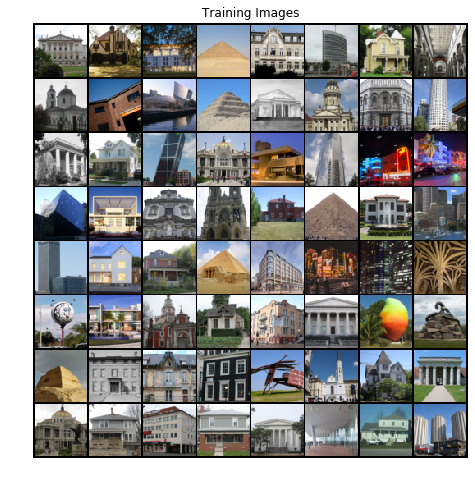

In [2]:
# Create the dataloader
dataset = dset.ImageFolder(root='arcDataset',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
print("here")
#transforms = transforms.Compose([transforms.ToTensor()])
print("here 1")
print("here 2 ")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
print("here 3")
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("here 4")
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [7]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [16]:
#### Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        #print(real_cpu)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        #print(netD(real_cpu))
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            

        iters += 1

Starting Training Loop...
[0/500][0/54]	Loss_D: 0.7749	Loss_G: 4.8359	D(x): 0.8221	D(G(z)): 0.3382 / 0.0210
[0/500][50/54]	Loss_D: 0.3207	Loss_G: 4.1266	D(x): 0.8023	D(G(z)): 0.0638 / 0.0265
[1/500][0/54]	Loss_D: 0.6989	Loss_G: 8.0217	D(x): 0.8976	D(G(z)): 0.3805 / 0.0012
[1/500][50/54]	Loss_D: 0.4136	Loss_G: 4.7518	D(x): 0.8546	D(G(z)): 0.1941 / 0.0146
[2/500][0/54]	Loss_D: 0.5491	Loss_G: 6.5103	D(x): 0.8729	D(G(z)): 0.3034 / 0.0027
[2/500][50/54]	Loss_D: 0.4693	Loss_G: 2.9286	D(x): 0.7023	D(G(z)): 0.0557 / 0.0784
[3/500][0/54]	Loss_D: 2.1234	Loss_G: 9.9419	D(x): 0.9944	D(G(z)): 0.7676 / 0.0007
[3/500][50/54]	Loss_D: 0.2931	Loss_G: 4.2789	D(x): 0.9211	D(G(z)): 0.1674 / 0.0245
[4/500][0/54]	Loss_D: 0.7527	Loss_G: 6.5831	D(x): 0.8047	D(G(z)): 0.2715 / 0.0024
[4/500][50/54]	Loss_D: 0.4599	Loss_G: 2.9710	D(x): 0.7414	D(G(z)): 0.1015 / 0.0805
[5/500][0/54]	Loss_D: 0.2842	Loss_G: 4.6170	D(x): 0.8641	D(G(z)): 0.0962 / 0.0241
[5/500][50/54]	Loss_D: 0.4032	Loss_G: 4.4365	D(x): 0.8479	D(G(z)): 

[49/500][50/54]	Loss_D: 0.1732	Loss_G: 3.1767	D(x): 0.9162	D(G(z)): 0.0725 / 0.0578
[50/500][0/54]	Loss_D: 2.4606	Loss_G: 10.0834	D(x): 0.9974	D(G(z)): 0.8518 / 0.0001
[50/500][50/54]	Loss_D: 0.2457	Loss_G: 3.4794	D(x): 0.8861	D(G(z)): 0.1006 / 0.0484
[51/500][0/54]	Loss_D: 3.2038	Loss_G: 11.2550	D(x): 0.9922	D(G(z)): 0.9074 / 0.0001
[51/500][50/54]	Loss_D: 0.2447	Loss_G: 4.6096	D(x): 0.9575	D(G(z)): 0.1653 / 0.0157
[52/500][0/54]	Loss_D: 2.6884	Loss_G: 10.6204	D(x): 0.9942	D(G(z)): 0.8559 / 0.0006
[52/500][50/54]	Loss_D: 0.3724	Loss_G: 5.3665	D(x): 0.9400	D(G(z)): 0.2396 / 0.0078
[53/500][0/54]	Loss_D: 0.2780	Loss_G: 5.2502	D(x): 0.9699	D(G(z)): 0.1871 / 0.0093
[53/500][50/54]	Loss_D: 0.1970	Loss_G: 3.8283	D(x): 0.9252	D(G(z)): 0.1007 / 0.0343
[54/500][0/54]	Loss_D: 7.2961	Loss_G: 8.1676	D(x): 0.9999	D(G(z)): 0.9979 / 0.0021
[54/500][50/54]	Loss_D: 0.3332	Loss_G: 4.3470	D(x): 0.9229	D(G(z)): 0.1885 / 0.0237
[55/500][0/54]	Loss_D: 0.3412	Loss_G: 4.1387	D(x): 0.8744	D(G(z)): 0.1528 / 0.

[99/500][0/54]	Loss_D: 0.4819	Loss_G: 6.5620	D(x): 0.8963	D(G(z)): 0.2051 / 0.0050
[99/500][50/54]	Loss_D: 0.2157	Loss_G: 3.8711	D(x): 0.9373	D(G(z)): 0.1247 / 0.0302
[100/500][0/54]	Loss_D: 0.2526	Loss_G: 3.5739	D(x): 0.8961	D(G(z)): 0.1060 / 0.0446
[100/500][50/54]	Loss_D: 0.1125	Loss_G: 4.4732	D(x): 0.9632	D(G(z)): 0.0678 / 0.0192
[101/500][0/54]	Loss_D: 0.2461	Loss_G: 3.4085	D(x): 0.8838	D(G(z)): 0.0874 / 0.0712
[101/500][50/54]	Loss_D: 0.2872	Loss_G: 4.4652	D(x): 0.9209	D(G(z)): 0.1679 / 0.0179
[102/500][0/54]	Loss_D: 0.2344	Loss_G: 3.2160	D(x): 0.9219	D(G(z)): 0.1177 / 0.0763
[102/500][50/54]	Loss_D: 0.1829	Loss_G: 4.2026	D(x): 0.9420	D(G(z)): 0.1076 / 0.0234
[103/500][0/54]	Loss_D: 1.8145	Loss_G: 11.5090	D(x): 0.9936	D(G(z)): 0.7073 / 0.0000
[103/500][50/54]	Loss_D: 0.2375	Loss_G: 3.6682	D(x): 0.8380	D(G(z)): 0.0389 / 0.0464
[104/500][0/54]	Loss_D: 3.2645	Loss_G: 9.2472	D(x): 0.9958	D(G(z)): 0.8805 / 0.0005
[104/500][50/54]	Loss_D: 0.1810	Loss_G: 2.7789	D(x): 0.8870	D(G(z)): 0.0

[147/500][50/54]	Loss_D: 0.1519	Loss_G: 3.4078	D(x): 0.8957	D(G(z)): 0.0350 / 0.0555
[148/500][0/54]	Loss_D: 5.6335	Loss_G: 8.7755	D(x): 0.9983	D(G(z)): 0.9478 / 0.0480
[148/500][50/54]	Loss_D: 0.2089	Loss_G: 3.8777	D(x): 0.9235	D(G(z)): 0.1055 / 0.0321
[149/500][0/54]	Loss_D: 1.9432	Loss_G: 10.6589	D(x): 0.9965	D(G(z)): 0.6789 / 0.0011
[149/500][50/54]	Loss_D: 0.1973	Loss_G: 3.0818	D(x): 0.8601	D(G(z)): 0.0352 / 0.0779
[150/500][0/54]	Loss_D: 0.1210	Loss_G: 3.9750	D(x): 0.9669	D(G(z)): 0.0776 / 0.0291
[150/500][50/54]	Loss_D: 0.1288	Loss_G: 3.7311	D(x): 0.9446	D(G(z)): 0.0650 / 0.0394
[151/500][0/54]	Loss_D: 0.0715	Loss_G: 4.3368	D(x): 0.9650	D(G(z)): 0.0329 / 0.0285
[151/500][50/54]	Loss_D: 0.1026	Loss_G: 3.6092	D(x): 0.9455	D(G(z)): 0.0434 / 0.0392
[152/500][0/54]	Loss_D: 1.4192	Loss_G: 8.8766	D(x): 0.9983	D(G(z)): 0.6132 / 0.0005
[152/500][50/54]	Loss_D: 0.1028	Loss_G: 3.8080	D(x): 0.9462	D(G(z)): 0.0436 / 0.0368
[153/500][0/54]	Loss_D: 0.1836	Loss_G: 4.9474	D(x): 0.9873	D(G(z)): 0

[196/500][0/54]	Loss_D: 0.1619	Loss_G: 4.7004	D(x): 0.9868	D(G(z)): 0.1261 / 0.0154
[196/500][50/54]	Loss_D: 0.0967	Loss_G: 4.5330	D(x): 0.9488	D(G(z)): 0.0389 / 0.0216
[197/500][0/54]	Loss_D: 0.1277	Loss_G: 5.0577	D(x): 0.9830	D(G(z)): 0.0974 / 0.0104
[197/500][50/54]	Loss_D: 0.0764	Loss_G: 4.5398	D(x): 0.9775	D(G(z)): 0.0465 / 0.0188
[198/500][0/54]	Loss_D: 0.0886	Loss_G: 5.0195	D(x): 0.9846	D(G(z)): 0.0625 / 0.0122
[198/500][50/54]	Loss_D: 0.0549	Loss_G: 5.0849	D(x): 0.9779	D(G(z)): 0.0302 / 0.0117
[199/500][0/54]	Loss_D: 0.0555	Loss_G: 4.5691	D(x): 0.9636	D(G(z)): 0.0174 / 0.0233
[199/500][50/54]	Loss_D: 0.0548	Loss_G: 4.8339	D(x): 0.9768	D(G(z)): 0.0295 / 0.0152
[200/500][0/54]	Loss_D: 0.0601	Loss_G: 5.0016	D(x): 0.9519	D(G(z)): 0.0100 / 0.0164
[200/500][50/54]	Loss_D: 0.0627	Loss_G: 4.8435	D(x): 0.9736	D(G(z)): 0.0341 / 0.0132
[201/500][0/54]	Loss_D: 2.4984	Loss_G: 13.7831	D(x): 0.9997	D(G(z)): 0.7769 / 0.0000
[201/500][50/54]	Loss_D: 0.2711	Loss_G: 3.3079	D(x): 0.8429	D(G(z)): 0

[244/500][50/54]	Loss_D: 0.0992	Loss_G: 5.3931	D(x): 0.9809	D(G(z)): 0.0631 / 0.0094
[245/500][0/54]	Loss_D: 0.4713	Loss_G: 9.3320	D(x): 0.9981	D(G(z)): 0.2973 / 0.0002
[245/500][50/54]	Loss_D: 0.0774	Loss_G: 4.5979	D(x): 0.9626	D(G(z)): 0.0346 / 0.0231
[246/500][0/54]	Loss_D: 0.0738	Loss_G: 4.9241	D(x): 0.9938	D(G(z)): 0.0616 / 0.0121
[246/500][50/54]	Loss_D: 0.0559	Loss_G: 5.0878	D(x): 0.9675	D(G(z)): 0.0214 / 0.0136
[247/500][0/54]	Loss_D: 0.0358	Loss_G: 5.0772	D(x): 0.9931	D(G(z)): 0.0273 / 0.0149
[247/500][50/54]	Loss_D: 0.0473	Loss_G: 5.2492	D(x): 0.9844	D(G(z)): 0.0302 / 0.0103
[248/500][0/54]	Loss_D: 0.3648	Loss_G: 9.5627	D(x): 0.9990	D(G(z)): 0.2466 / 0.0001
[248/500][50/54]	Loss_D: 0.0482	Loss_G: 4.9090	D(x): 0.9753	D(G(z)): 0.0220 / 0.0156
[249/500][0/54]	Loss_D: 0.4438	Loss_G: 10.6420	D(x): 0.9981	D(G(z)): 0.2889 / 0.0001
[249/500][50/54]	Loss_D: 0.0377	Loss_G: 5.0630	D(x): 0.9831	D(G(z)): 0.0199 / 0.0115
[250/500][0/54]	Loss_D: 0.0471	Loss_G: 5.2681	D(x): 0.9875	D(G(z)): 0

[293/500][0/54]	Loss_D: 0.2415	Loss_G: 7.1302	D(x): 0.9933	D(G(z)): 0.1605 / 0.0019
[293/500][50/54]	Loss_D: 0.0399	Loss_G: 5.5942	D(x): 0.9822	D(G(z)): 0.0200 / 0.0083
[294/500][0/54]	Loss_D: 1.8333	Loss_G: 12.6152	D(x): 0.9997	D(G(z)): 0.6781 / 0.0001
[294/500][50/54]	Loss_D: 0.0587	Loss_G: 5.1495	D(x): 0.9688	D(G(z)): 0.0246 / 0.0141
[295/500][0/54]	Loss_D: 0.0852	Loss_G: 5.7268	D(x): 0.9941	D(G(z)): 0.0670 / 0.0068
[295/500][50/54]	Loss_D: 0.0422	Loss_G: 5.5334	D(x): 0.9675	D(G(z)): 0.0079 / 0.0087
[296/500][0/54]	Loss_D: 0.0328	Loss_G: 5.7394	D(x): 0.9918	D(G(z)): 0.0226 / 0.0088
[296/500][50/54]	Loss_D: 0.0297	Loss_G: 5.4969	D(x): 0.9901	D(G(z)): 0.0189 / 0.0096
[297/500][0/54]	Loss_D: 0.0325	Loss_G: 5.2871	D(x): 0.9926	D(G(z)): 0.0238 / 0.0126
[297/500][50/54]	Loss_D: 0.0342	Loss_G: 5.3343	D(x): 0.9870	D(G(z)): 0.0201 / 0.0104
[298/500][0/54]	Loss_D: 0.0206	Loss_G: 6.0805	D(x): 0.9929	D(G(z)): 0.0130 / 0.0077
[298/500][50/54]	Loss_D: 0.0259	Loss_G: 5.5806	D(x): 0.9932	D(G(z)): 0

[341/500][50/54]	Loss_D: 0.0181	Loss_G: 6.0392	D(x): 0.9895	D(G(z)): 0.0074 / 0.0054
[342/500][0/54]	Loss_D: 0.0225	Loss_G: 5.7771	D(x): 0.9966	D(G(z)): 0.0184 / 0.0071
[342/500][50/54]	Loss_D: 0.0142	Loss_G: 6.2685	D(x): 0.9917	D(G(z)): 0.0057 / 0.0055
[343/500][0/54]	Loss_D: 0.0252	Loss_G: 5.6751	D(x): 0.9993	D(G(z)): 0.0230 / 0.0067
[343/500][50/54]	Loss_D: 0.0168	Loss_G: 6.2567	D(x): 0.9889	D(G(z)): 0.0054 / 0.0048
[344/500][0/54]	Loss_D: 0.0907	Loss_G: 7.9032	D(x): 0.9987	D(G(z)): 0.0773 / 0.0006
[344/500][50/54]	Loss_D: 0.0125	Loss_G: 6.3710	D(x): 0.9942	D(G(z)): 0.0066 / 0.0042
[345/500][0/54]	Loss_D: 0.0245	Loss_G: 6.1931	D(x): 0.9975	D(G(z)): 0.0208 / 0.0045
[345/500][50/54]	Loss_D: 0.0131	Loss_G: 6.0986	D(x): 0.9905	D(G(z)): 0.0035 / 0.0049
[346/500][0/54]	Loss_D: 0.0119	Loss_G: 6.5971	D(x): 0.9918	D(G(z)): 0.0036 / 0.0036
[346/500][50/54]	Loss_D: 0.0122	Loss_G: 6.1053	D(x): 0.9970	D(G(z)): 0.0090 / 0.0054
[347/500][0/54]	Loss_D: 0.0058	Loss_G: 6.7529	D(x): 0.9983	D(G(z)): 0.

KeyboardInterrupt: 

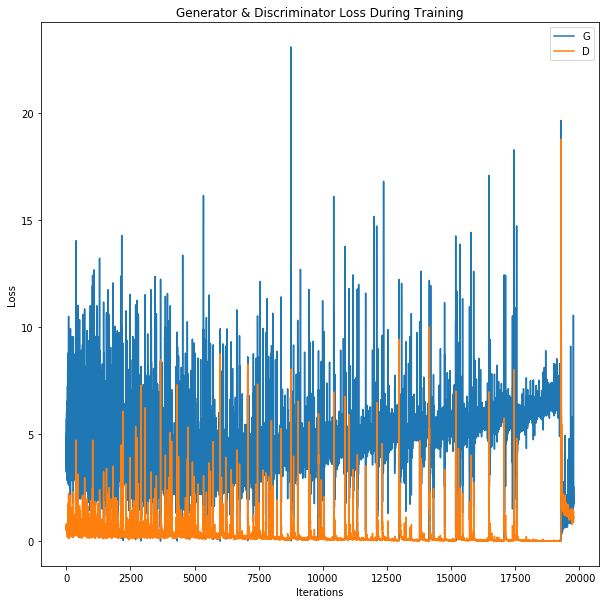

In [17]:
plt.figure(figsize=(10,10))
plt.title("Generator & Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label=
         "D")
plt.xlabel("Iterations")

plt.ylabel("Loss")
plt.legend()
plt.show()

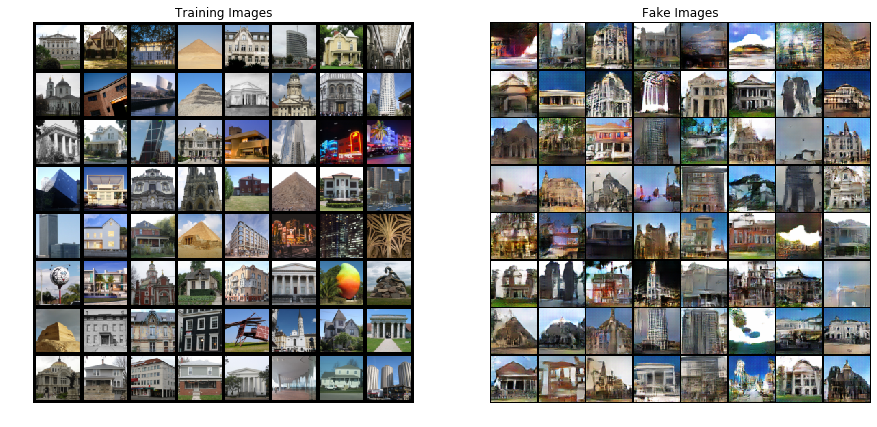

In [18]:
# Grab a batch of real images from the dataloader

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()